In [2]:
import numpy as np
import pandas as pd
import math
import os
import gzip
import copy
import numbers
import json as json
import matplotlib.pyplot as plt 
import matplotlib

import autograd.numpy as np
import celerite
from celerite import terms
from celerite import GP
from scipy.optimize import minimize

In [7]:
class DRW_kernel(terms.Term):
	parameter_names = ("a", "c")
	def __repr__(self):
		return "DRW_kernel({0.a}, {0.c})".format(self)
	def get_real_coefficients(self, params):
		a, c = params
		return a, 1.0/c

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

In [8]:
def GP_lc(mjd, band, band_err):
    
    kernel = DRW_kernel(np.var(band),500)
    gp = GP(kernel, mean=np.mean(band), fit_mean = True)
    gp.compute(mjd, band_err)  

    print("Initial log likelihood: {0}".format(gp.log_likelihood(band)))  
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
    print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
    print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))
    
    #find the maximum likelihood parameters for this model
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(band, gp))
    gp.set_parameter_vector(soln.x)
    print("Final log-likelihood: {0}".format(-soln.fun))
    print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
    
    return gp



In [9]:
def predict_lc(gp, mjd, band_name, band, band_err):
    continuous_mjd = np.linspace(min(mjd),max(mjd),2000)
    pred_mean, pred_var = gp.predict(band, continuous_mjd, return_var=True)
    pred_std = np.sqrt(pred_var)
   
    #plot the predicted light curve
    color = "#ff7f0e"
    plt.figure(figsize = (20,10))
    plt.errorbar(mjd, band, yerr=band_err, fmt=".k", capsize=0)
    plt.plot(continuous_mjd, pred_mean, color=color)
    plt.fill_between(continuous_mjd, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none")
    plt.xlabel("mjd (days)",fontsize=20)
    plt.ylabel("flux",fontsize=20)
    plt.title(band_name+' band maximum likelihood prediction',fontsize=20)
    plt.show()

In [10]:
def calculate_obs_SF(mjd, flux, band):
    # structure function
    
    # convert mjd to integer
    mjd = mjd.astype(int).tolist()
    flux = flux.astype(float).tolist()
    
    #initialize the delta time
    delta = 1
    obs_SF_list = []
    delta_list = []
    obs_len = max(mjd) - min(mjd)
    while delta < obs_len:
        n = min(mjd)
        count = 0
        mag_vals = 0.0
        while n <= max(mjd)-delta:
            if n in mjd and n+delta in mjd: 
                mag_vals += (flux[mjd.index(n+delta)] - flux[mjd.index(n)])**2   
                count +=1
            n = n + delta
        if count>0:
            obs_SF_list.append(np.sqrt(mag_vals/count))
            delta_list.append(delta)  
        delta +=1
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, obs_SF_list, label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('Time lag', fontsize=20)
    plt.xscale('log')
#     plt.yscale('log')
    plt.legend(fontsize = 20)
    plt.ylabel('Structure Function', fontsize=20)
    plt.title('Structure Function (Observed) ' + band +' band',fontsize=20 )
    return obs_SF_list, delta_list
    

In [11]:
def calculate_true_SF(obs_SF_list, delta_list, flux, flux_err, band):
    true_SF_list = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
    else:
        var_noise = 0
    for i in obs_SF_list:
        true_SF_list.append(np.sqrt(i**2 - 2*var_noise))
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, true_SF_list,label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('Time lag', fontsize=20)
    plt.legend(fontsize = 20)
    plt.xscale('log')
#     plt.yscale('log')
    plt.ylabel('Structure Function', fontsize=20)
    plt.title('Structure Function (True) ' + band +' band', fontsize=20)

In [12]:
def caculate_ACF( obs_SF_list, delta_list,flux, flux_err, band):
    #autocorrelation function ACF
    ACF = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
    else:
        var_noise = 0
    var_signal = np.var(flux)
    for i in obs_SF_list:
        ACF.append(1 + (2*var_noise - i**2)/(2*var_signal))
    
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, ACF)
    plt.xlabel('Time lag', fontsize=20)
#     plt.xscale('log')
#     plt.yscale('log')
    plt.ylabel('ACF ', fontsize=20)  
    plt.title('ACF' + band +' band', fontsize=20)

In [13]:
def plot_PSD(mjd, mag, band):
    from scipy import signal
    freqs, times, spectrogram = signal.spectrogram(mag)
    plt.figure(figsize = (20,10))
    plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
    plt.title('Spectrogram ' + band +' band', fontsize=20)
    plt.ylabel('Frequency band', fontsize=20)
    plt.xlabel('Time window', fontsize=20)
    plt.tight_layout()
    
    freqs, psd = signal.welch(mag)
    plt.figure(figsize = (20,10))
    plt.semilogx(freqs, psd)
    plt.title('PSD: power spectral density ' + band +' band', fontsize=20)
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Power', fontsize=20)
    plt.tight_layout()

In [12]:
def plot_lc(target):
    plt.figure(figsize = (20,10))
    plt.title('Object id: '+str(target['id'].tolist()[0]))
    plt.errorbar(target['mjd'], target['u'], yerr = target['u_error'], alpha = 0.6,fmt='o',ecolor='blue',color='blue',elinewidth=2,capsize=3,ms=5,label = 'u')
    plt.errorbar(target['mjd'], target['g'], yerr = target['g_error'], alpha = 0.6,fmt='o',ecolor='green',color='green',elinewidth=2,capsize=3,ms=5,label = 'g')
    plt.errorbar(target['mjd'], target['r'], yerr = target['r_error'], alpha = 0.6,fmt='o',ecolor='r',color='r',elinewidth=2,capsize=3,ms=5,label = 'r')
    plt.errorbar(target['mjd'], target['i'], yerr = target['i_error'], alpha = 0.6,fmt='o',ecolor='orange',color='orange',elinewidth=2,capsize=3,ms=5,label = 'i')
    plt.errorbar(target['mjd'], target['z'], yerr = target['z_error'], alpha = 0.6,fmt='o',ecolor='black',color='black',elinewidth=2,capsize=3,ms=5,label = 'z')
    plt.legend(loc="upper right",fontsize=20)
    plt.xlabel("Time (days)",fontsize=20)
    plt.ylabel("Mag",fontsize=20)

In [13]:
data = pd.read_csv('../processed/unbalanced/final_v1.csv')

In [39]:
obj = 8658191460512956634
target = data[data.id == obj]

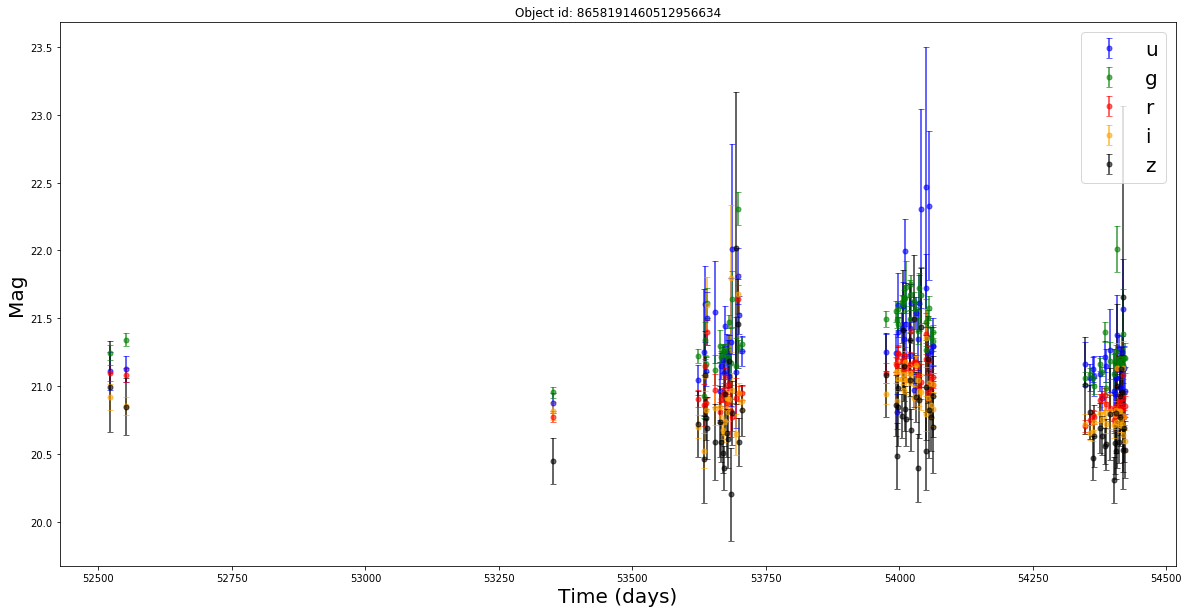

In [40]:
plot_lc(target)

sigma_in 0.200000,  tau_in 300.000000
parameter_vector:
[-1.39794001 -2.47712125]

Initial log likelihood: -4.509013698159279
parameter_dict:
OrderedDict([('kernel:log_a', -1.3979400086720375), ('kernel:log_c', -2.4771212547196626)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.39794001 -2.47712125]

parameter_bounds:
[(None, None), (None, None)]

      fun: -32.51282614452457
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.41584530e-05, -1.42108547e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 9
   status: 0
  success: True
        x: array([-4.25213601, -4.63855764])
sigma_fit 0.119305,  tau_fit 103.395107


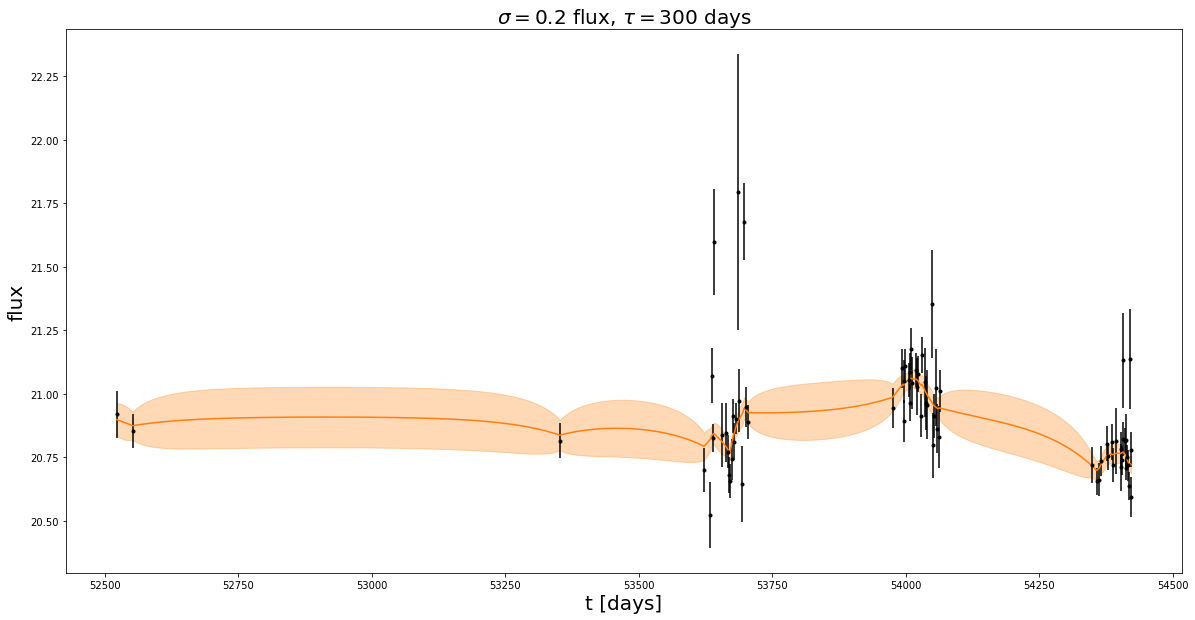

In [48]:
# a simple test
i = 'i'

# sf = SF_dict[i]
sigma_in = 0.2
tau_in = 300

print("sigma_in %f,  tau_in %f"%(sigma_in,tau_in))

kernel = terms.RealTerm(log_a = 2 * np.log10(sigma_in) , log_c = np.log10(1/tau_in))

gp = celerite.GP(kernel, mean=np.mean(target[i]))
gp.compute(target['mjd'], target[i+'_error'])

# print some info 
print("Initial log likelihood: {0}".format(gp.log_likelihood(target[i])))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))


from scipy.optimize import minimize
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(target[i], gp))
gp.set_parameter_vector(r.x)
print(r)

res = gp.get_parameter_dict()
sigma = np.exp(res['kernel:log_a']/2)
tau = 1.0 / np.exp(res['kernel:log_c'])
print("sigma_fit %f,  tau_fit %f"%(sigma,tau))

# print(min(target['mjd']),max(target['mjd']))

x = np.linspace(min(target['mjd']),max(target['mjd']), 5000)
pred_mean, pred_var = gp.predict(target[i], x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.errorbar(target['mjd'], target[i], yerr=target[i+'_error'], fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)
ax.set_title(r'$\sigma=$'+str(sigma_in)+' flux, '+r'$\tau=$'+str(tau_in)+' days',fontsize=20)
plt.savefig('DRW_simulate_tau_100_sigma_0.2_regular.png', bbox_inches='tight')

### Original light curve analysis: Structure Fucntion, ACF and PSD

/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 22, using nperseg = 22
  .format(nperseg, input_length))
/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 22, using nperseg = 22
  .format(nperseg, input_length))
/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/sherrysheng/opt/anaconda3/env

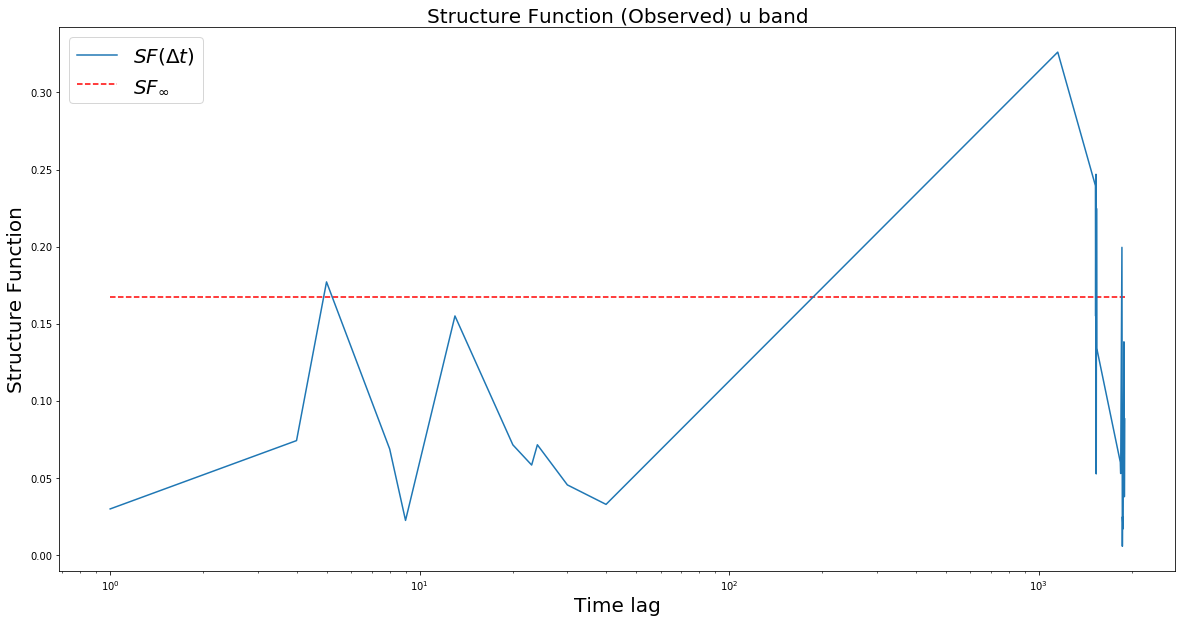

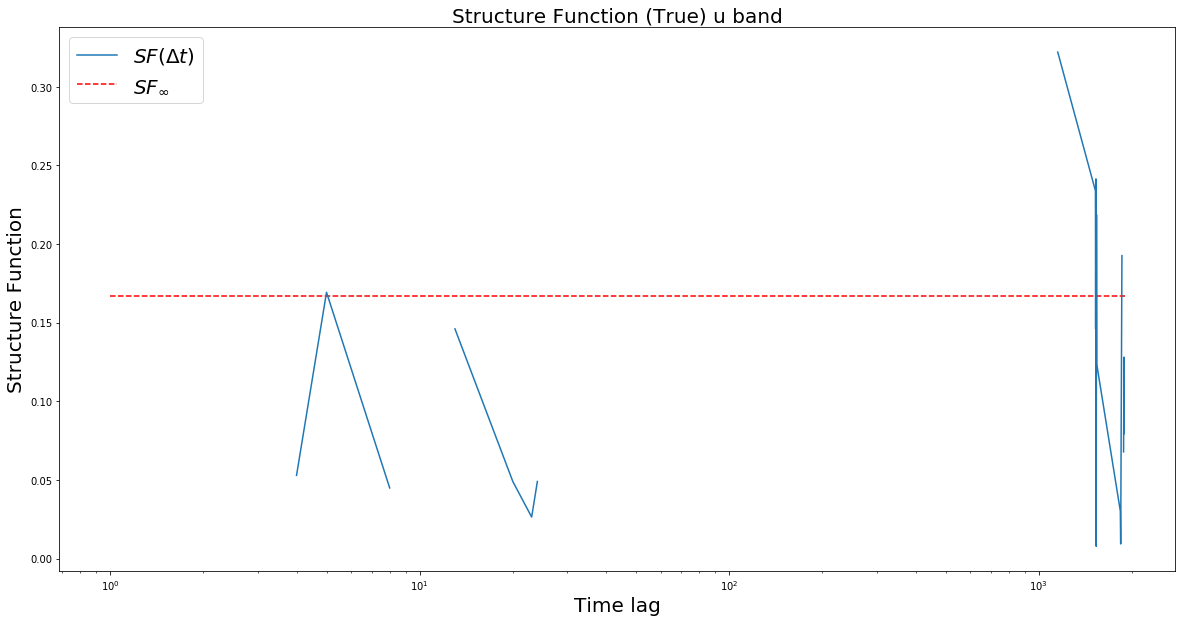

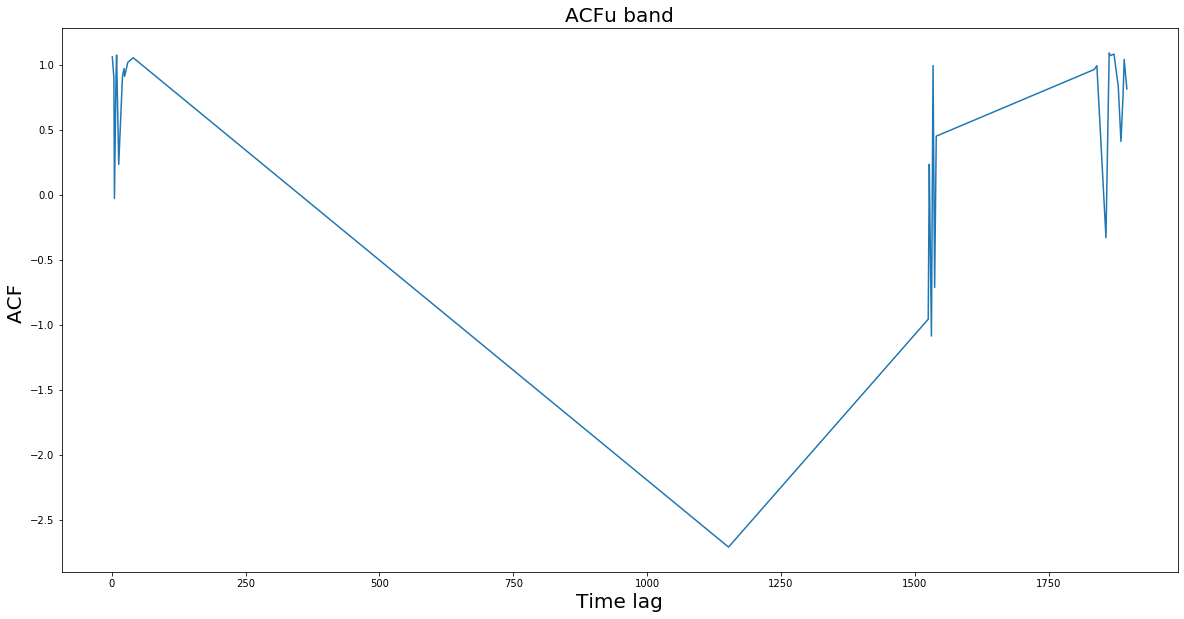

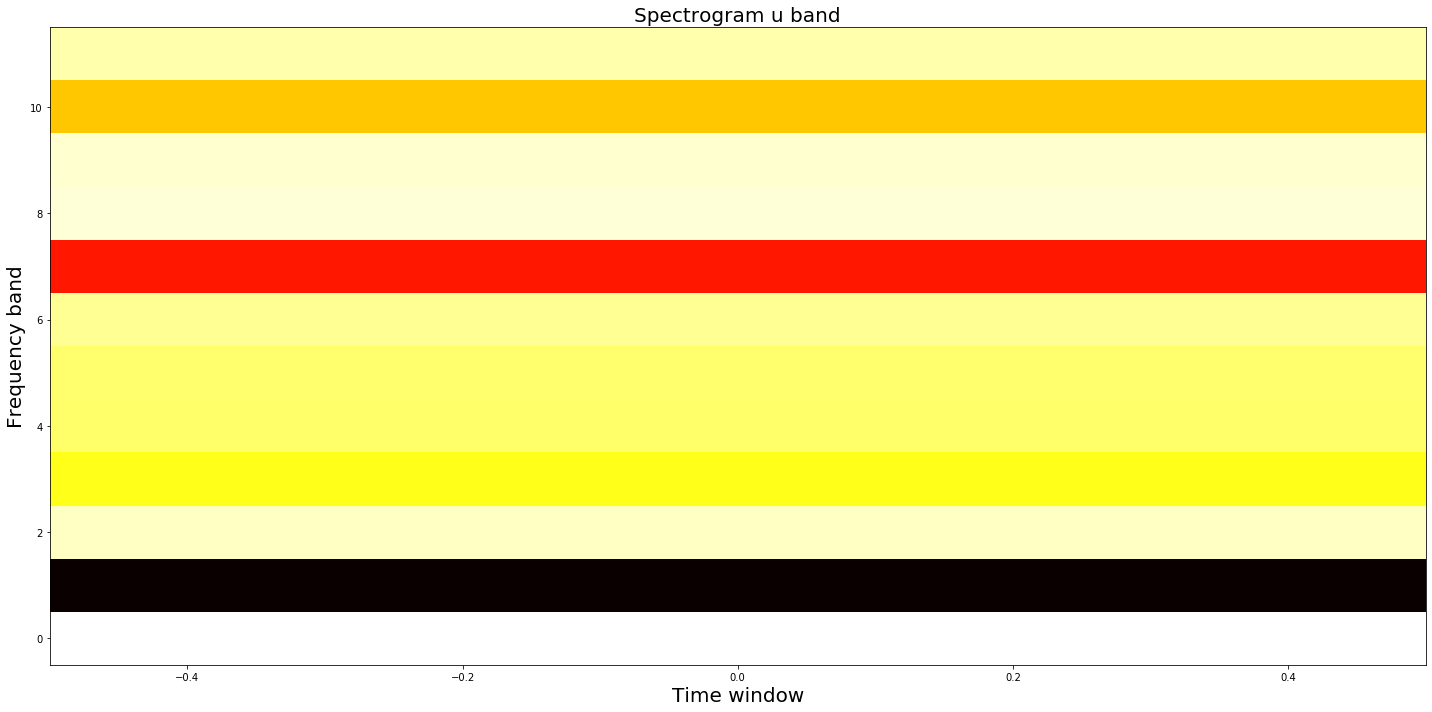

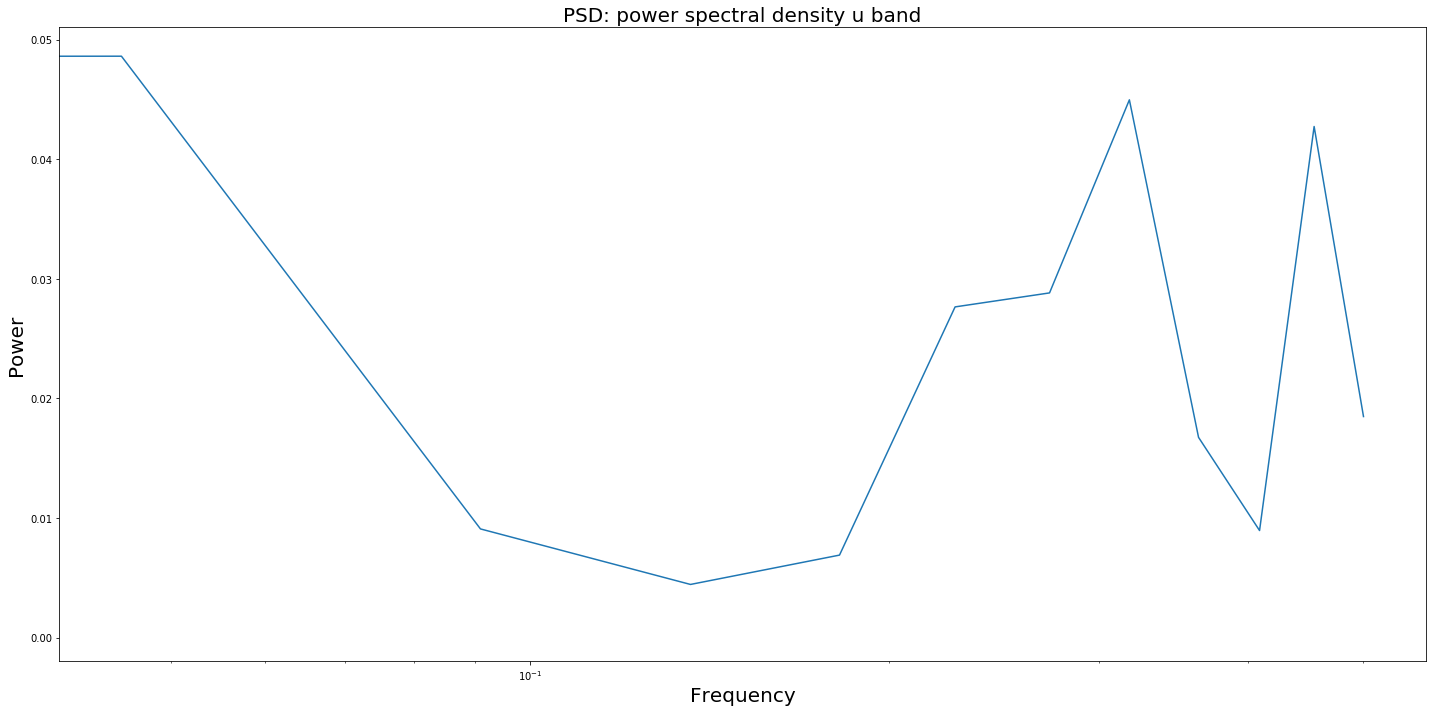

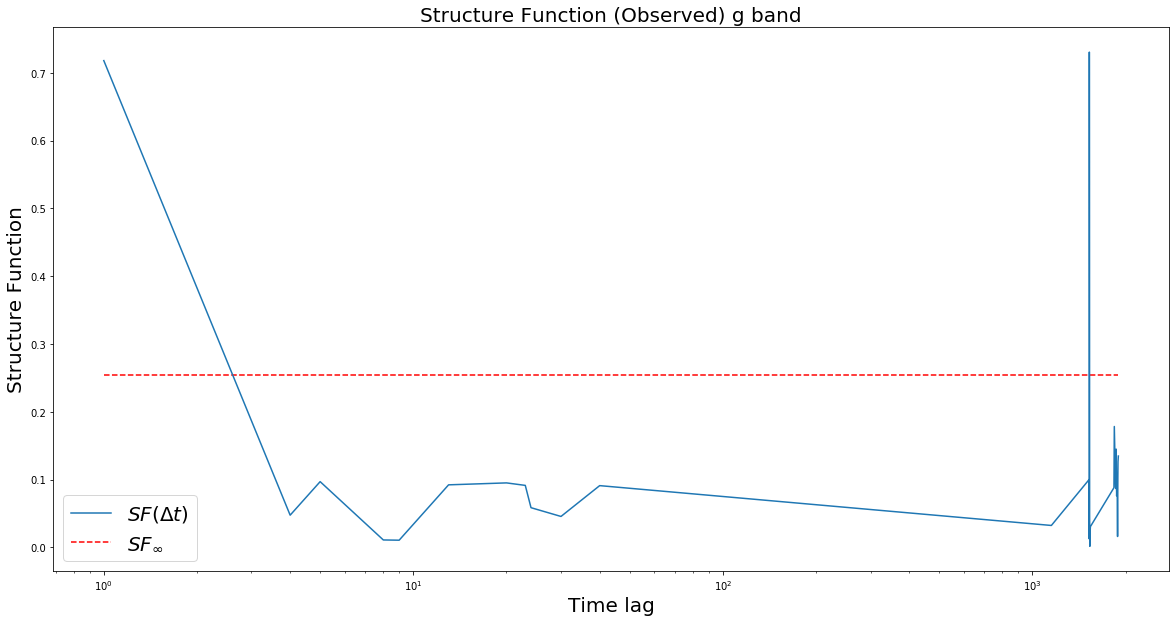

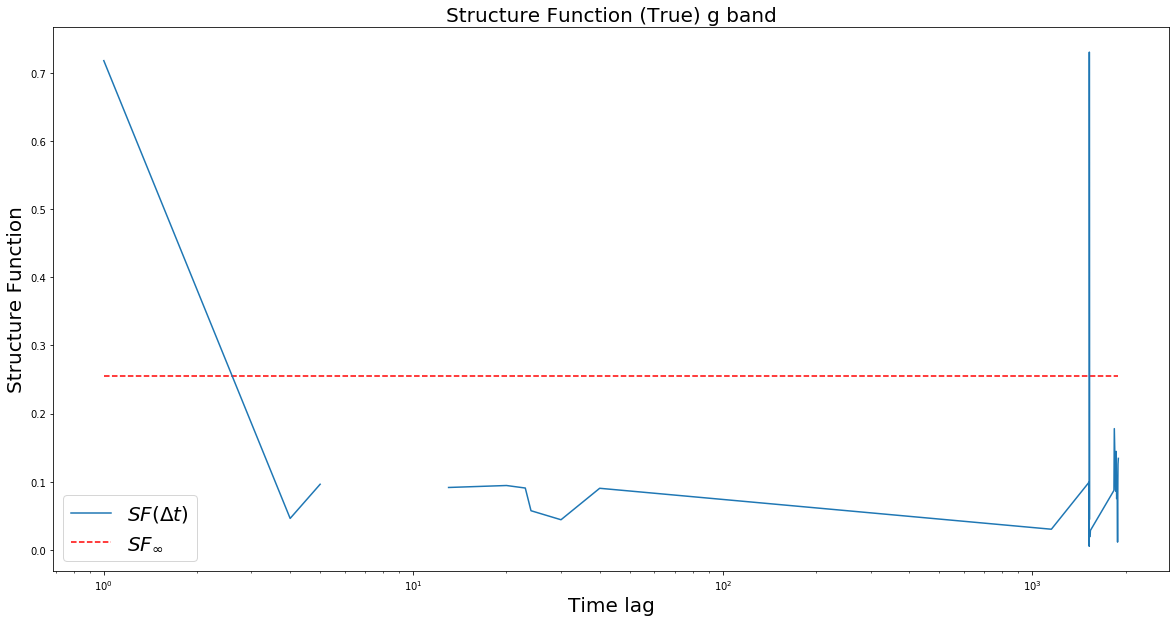

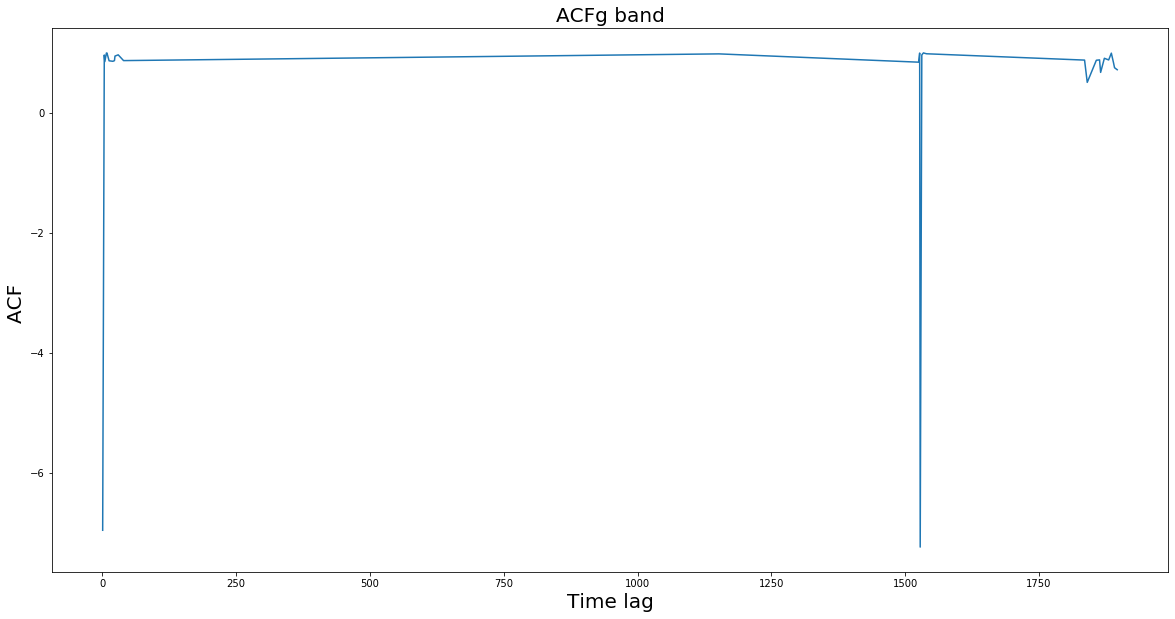

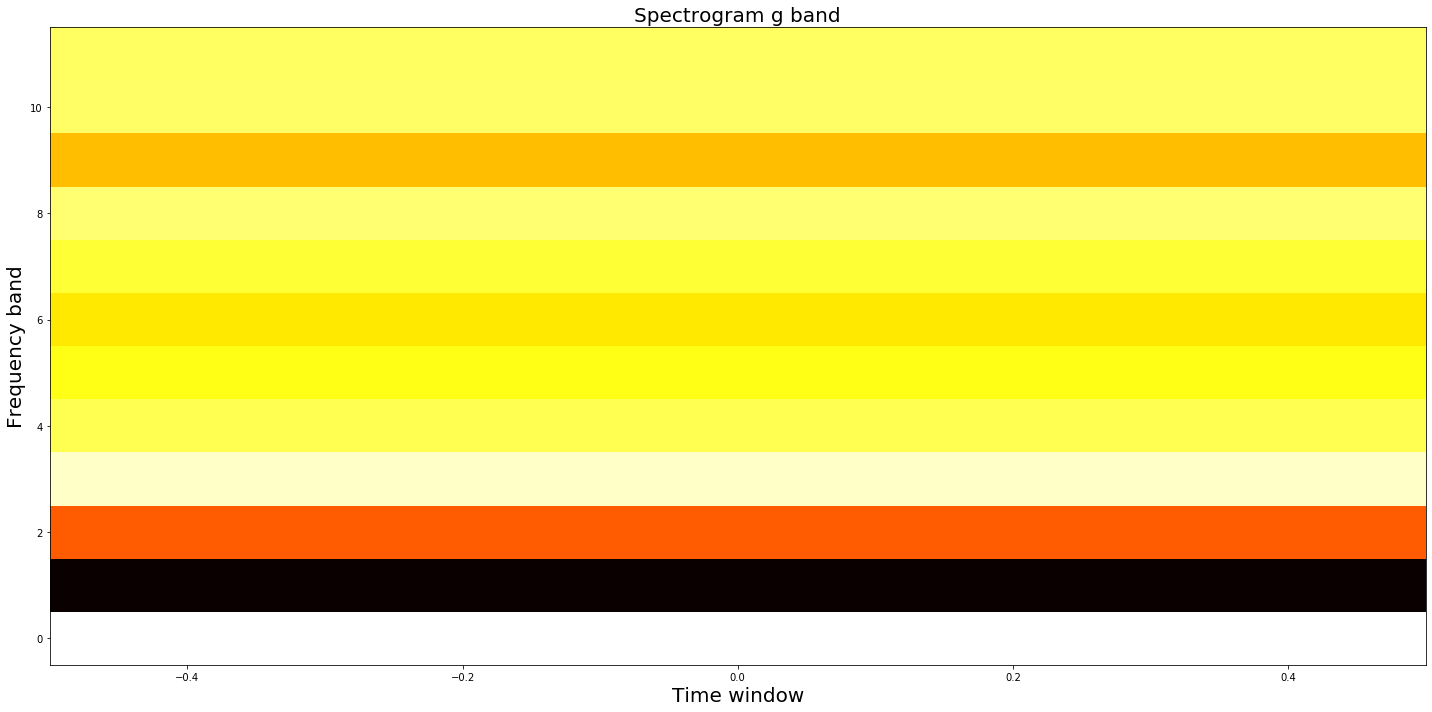

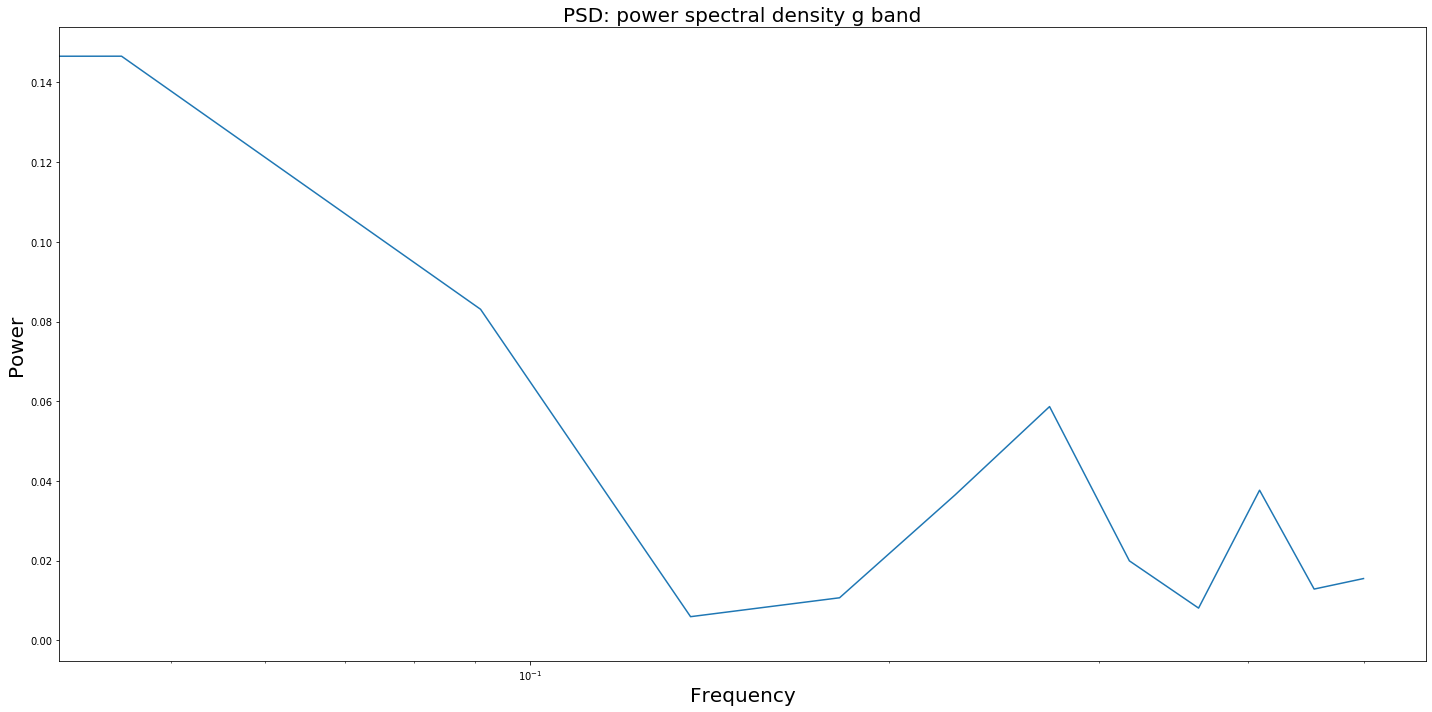

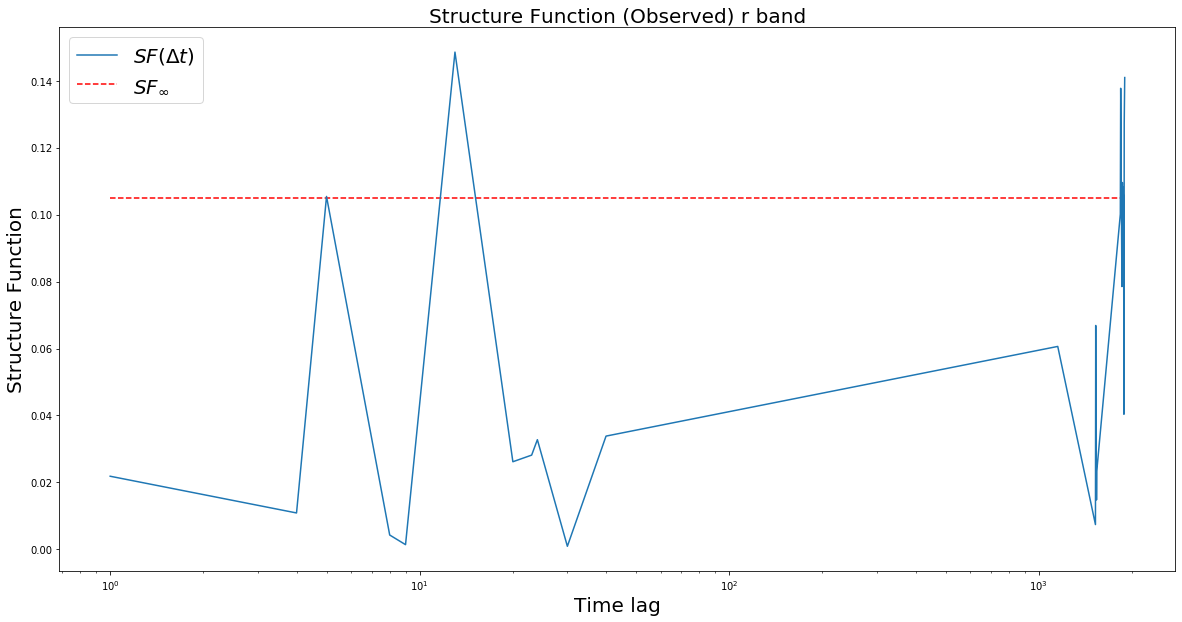

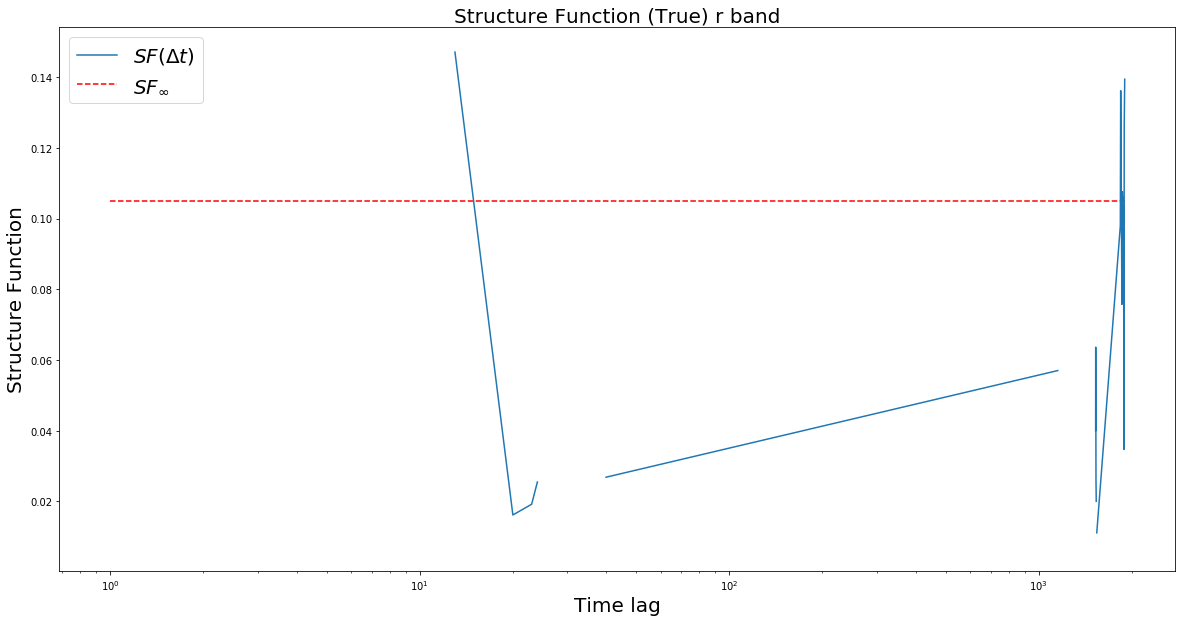

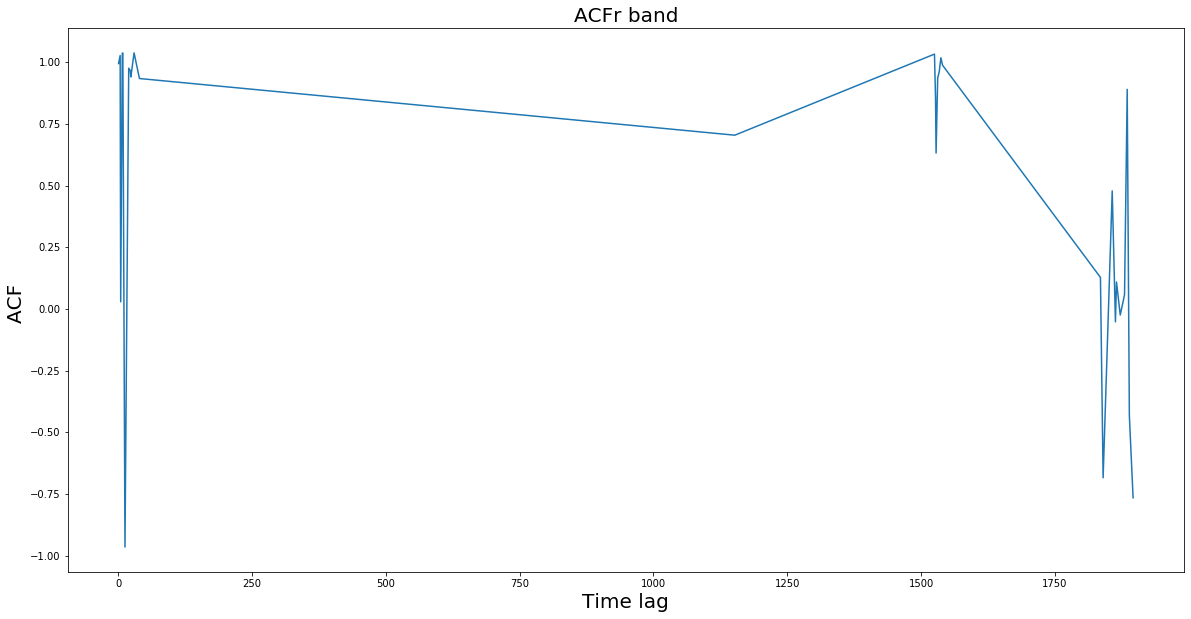

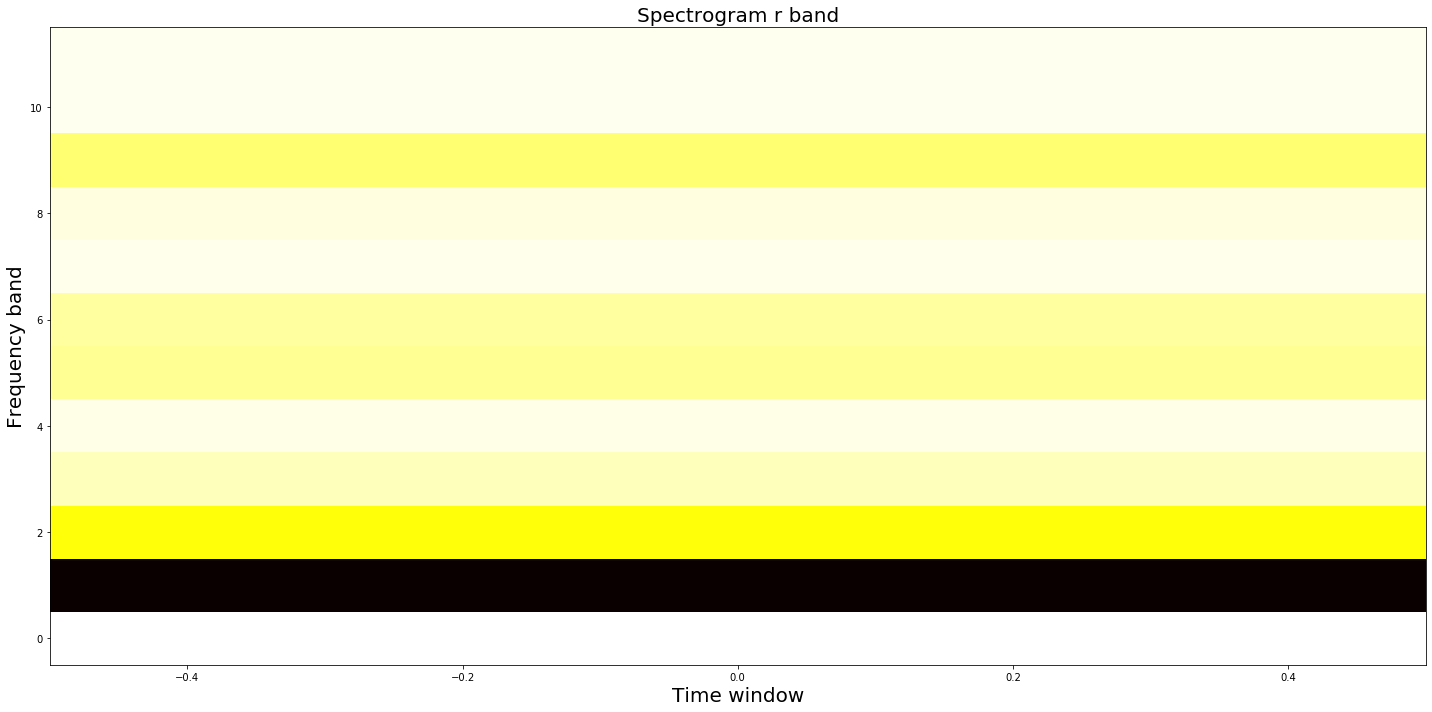

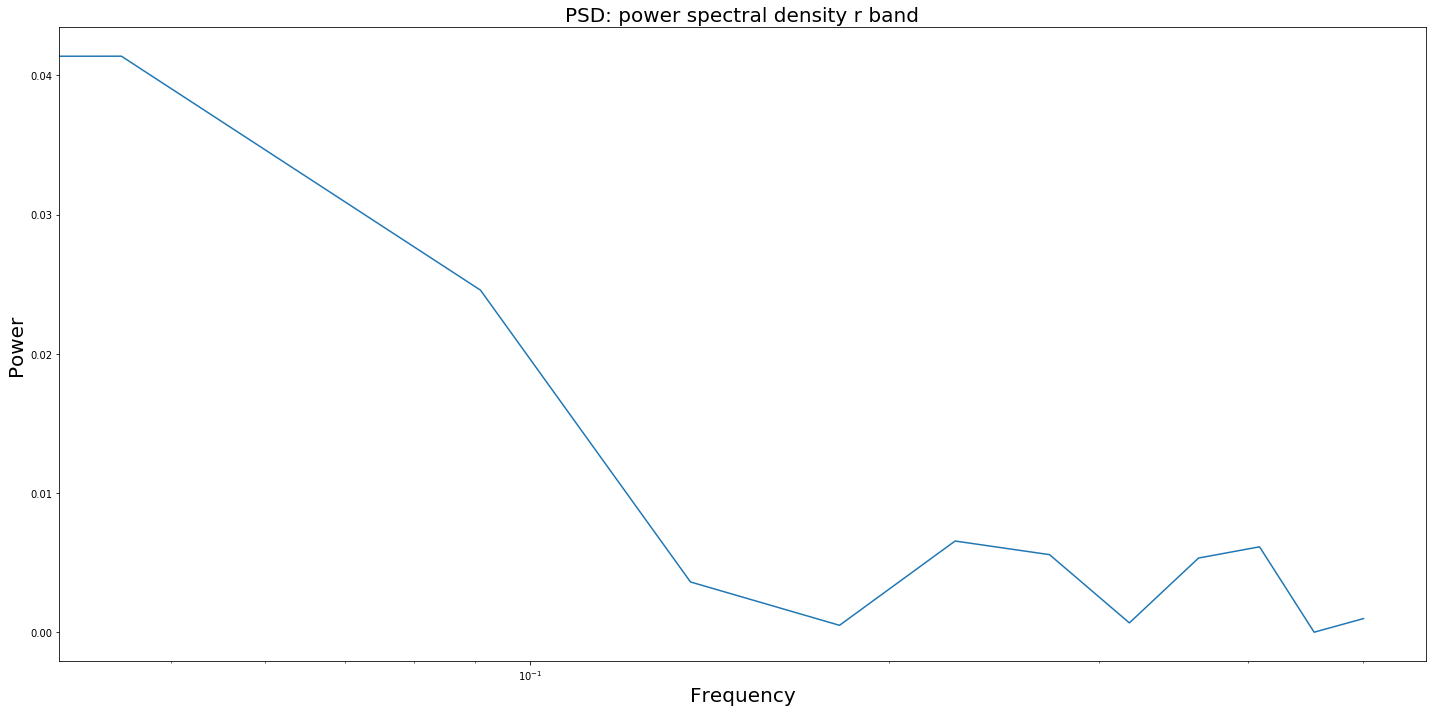

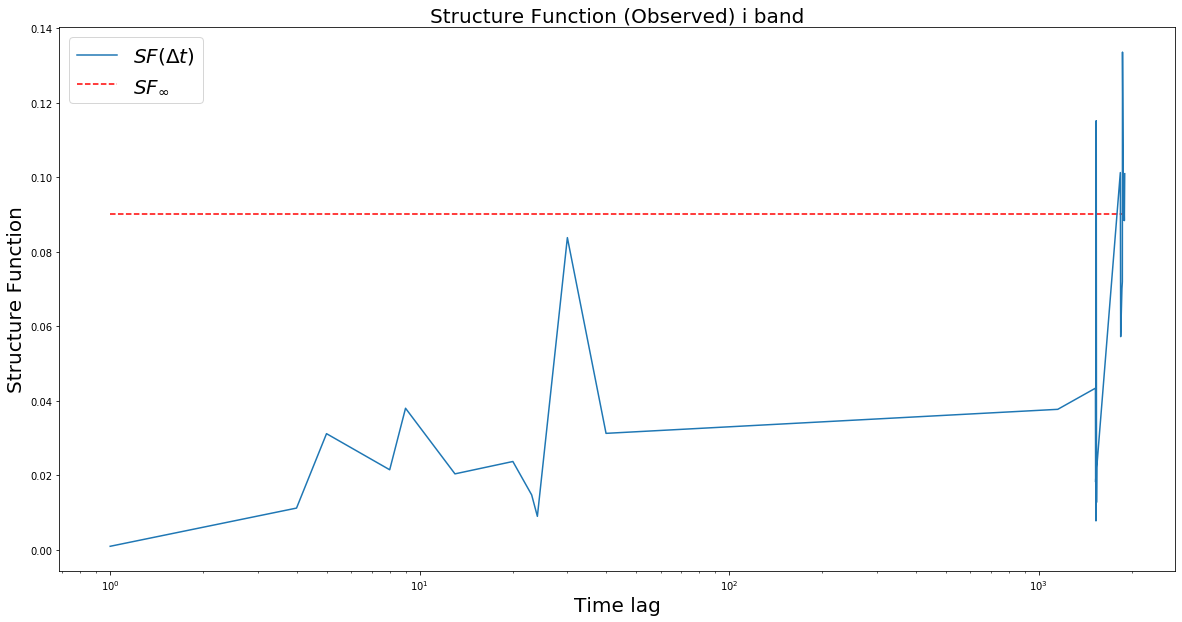

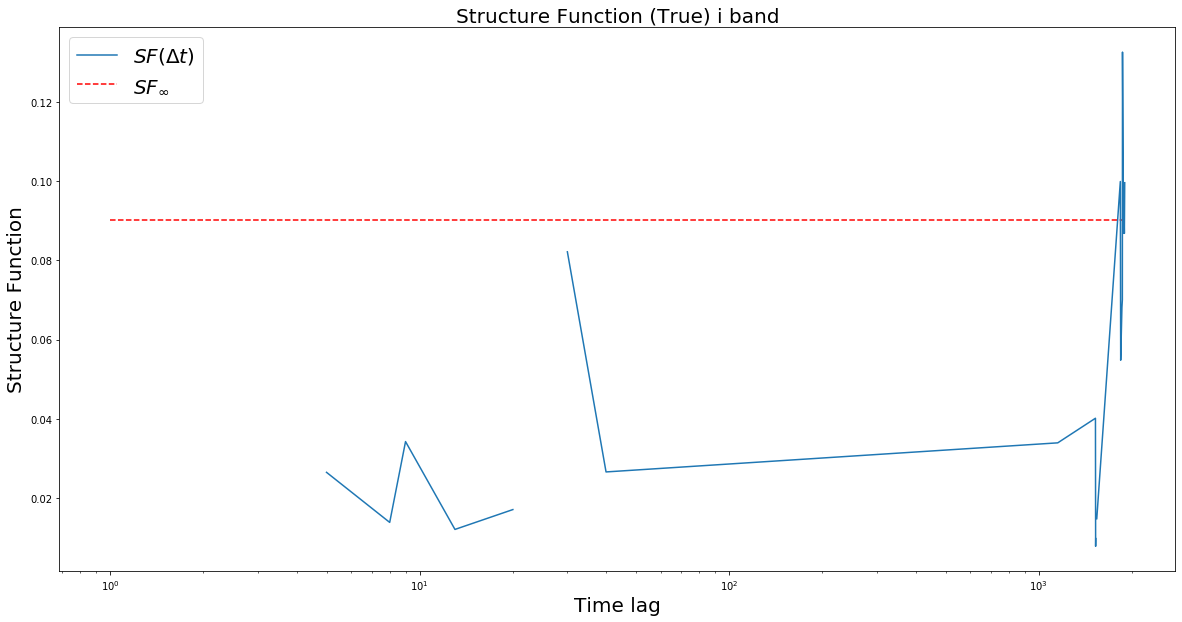

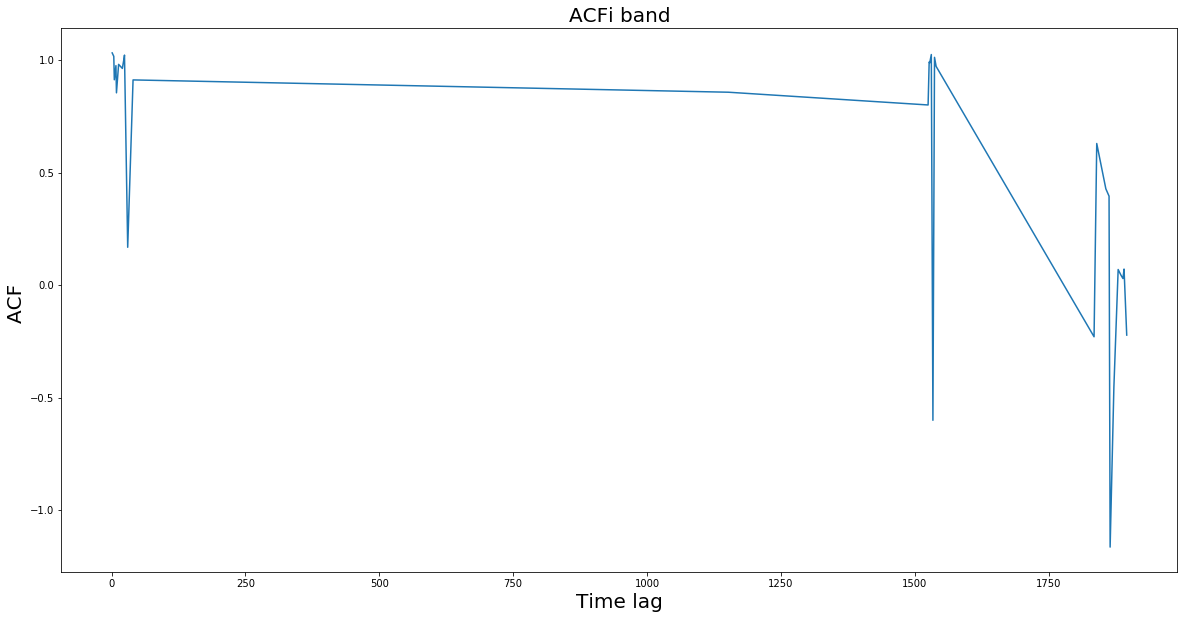

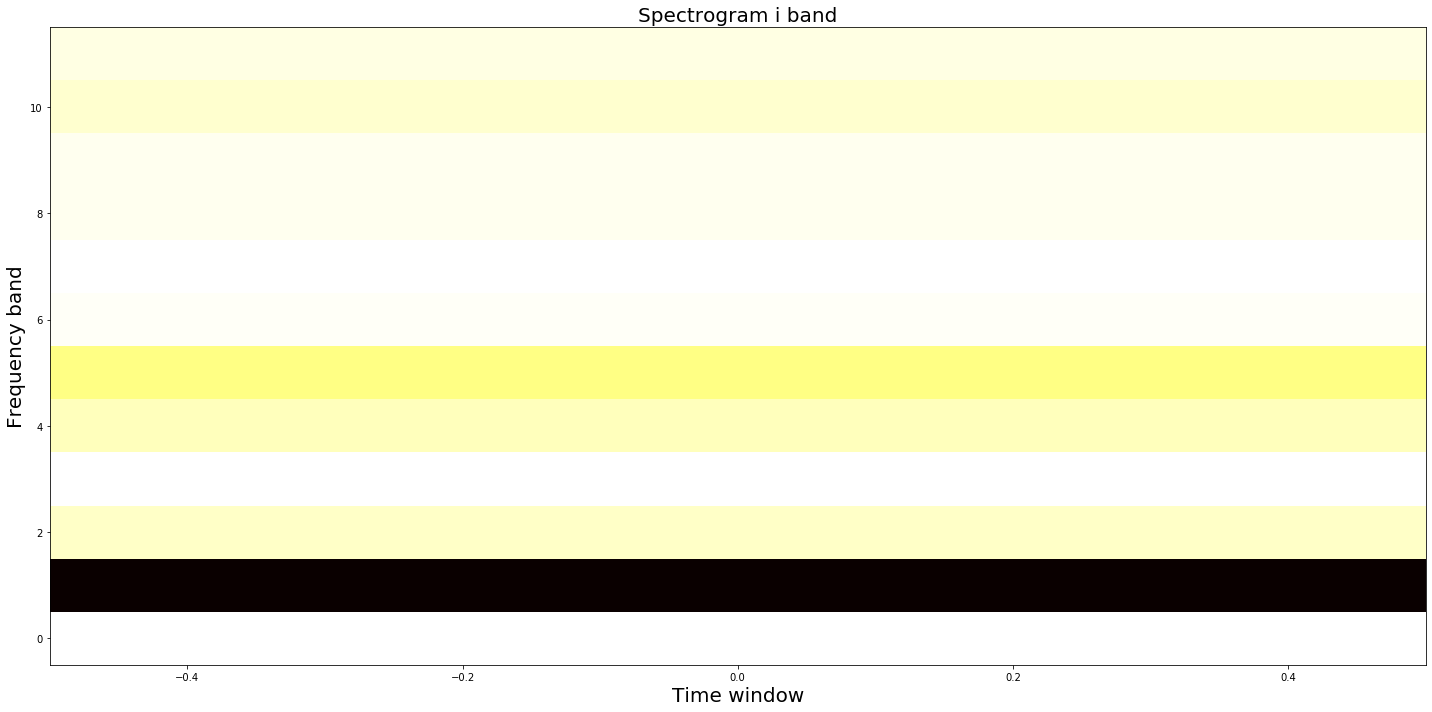

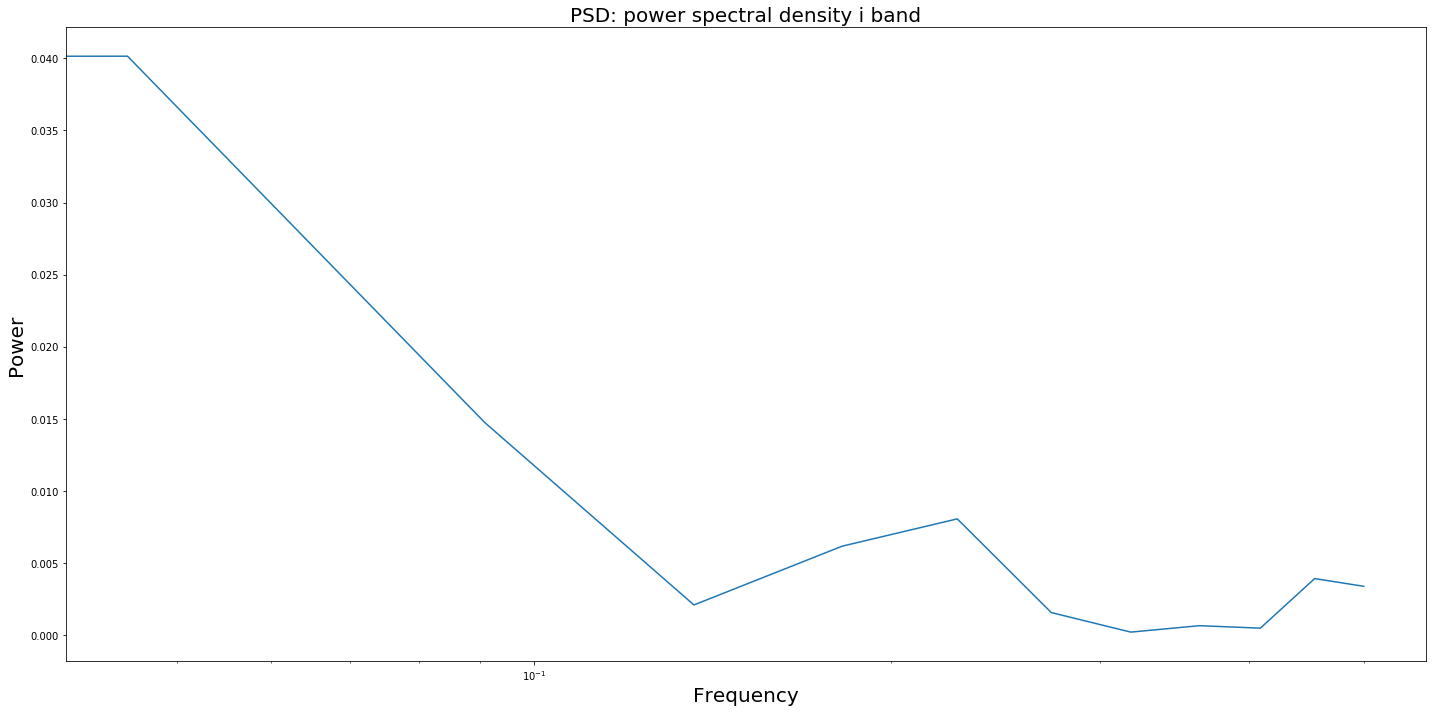

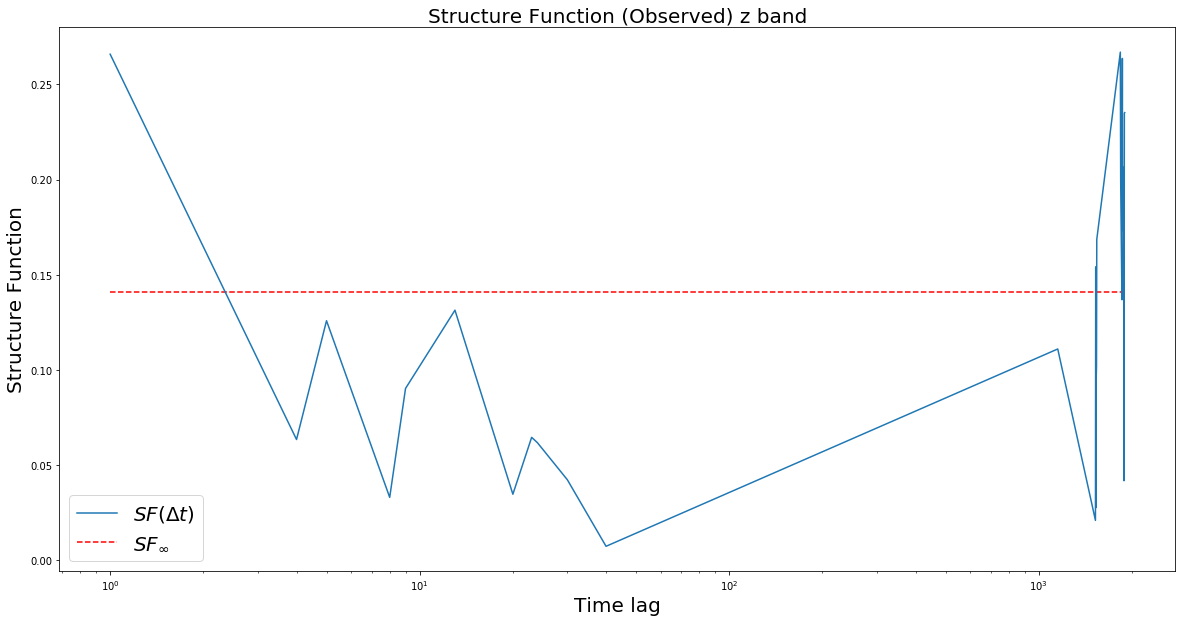

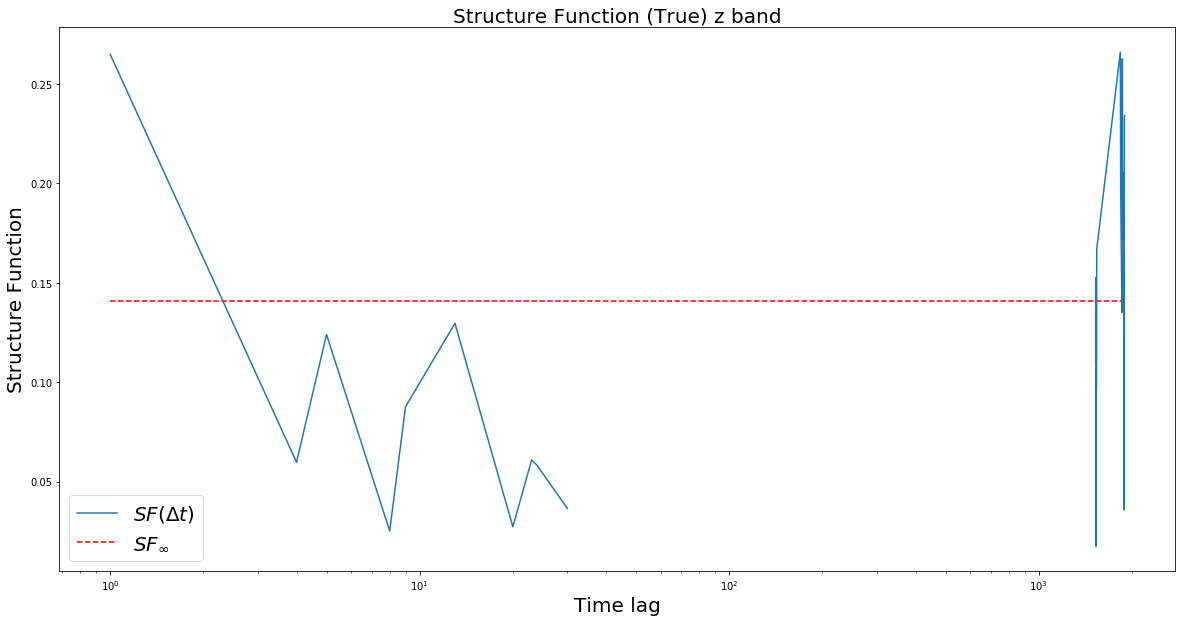

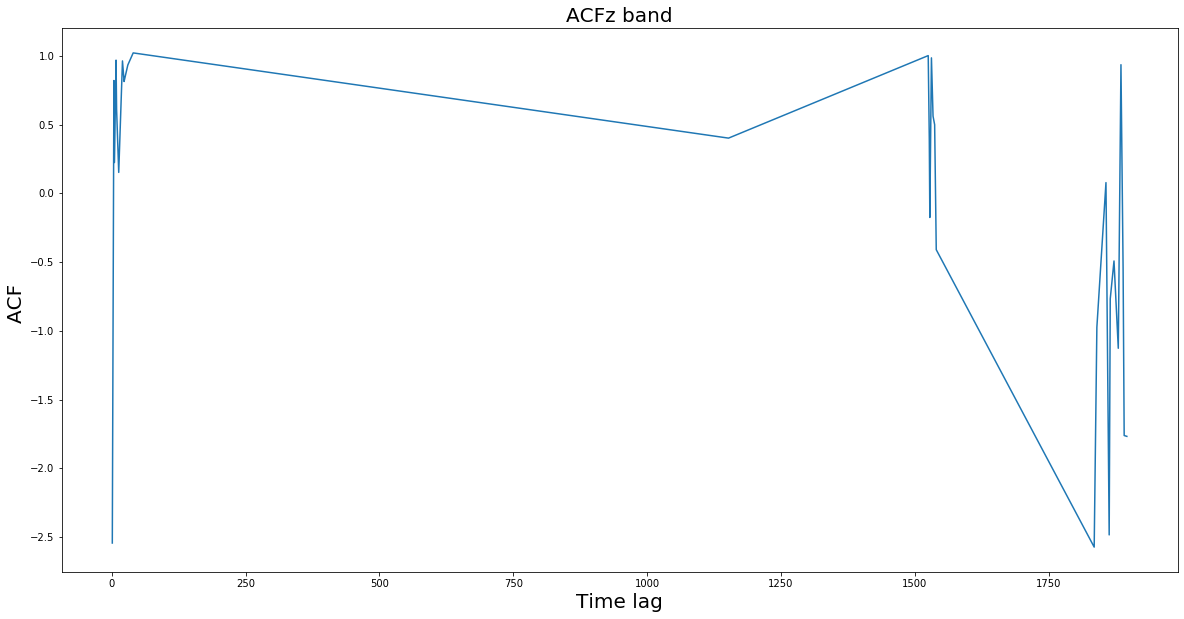

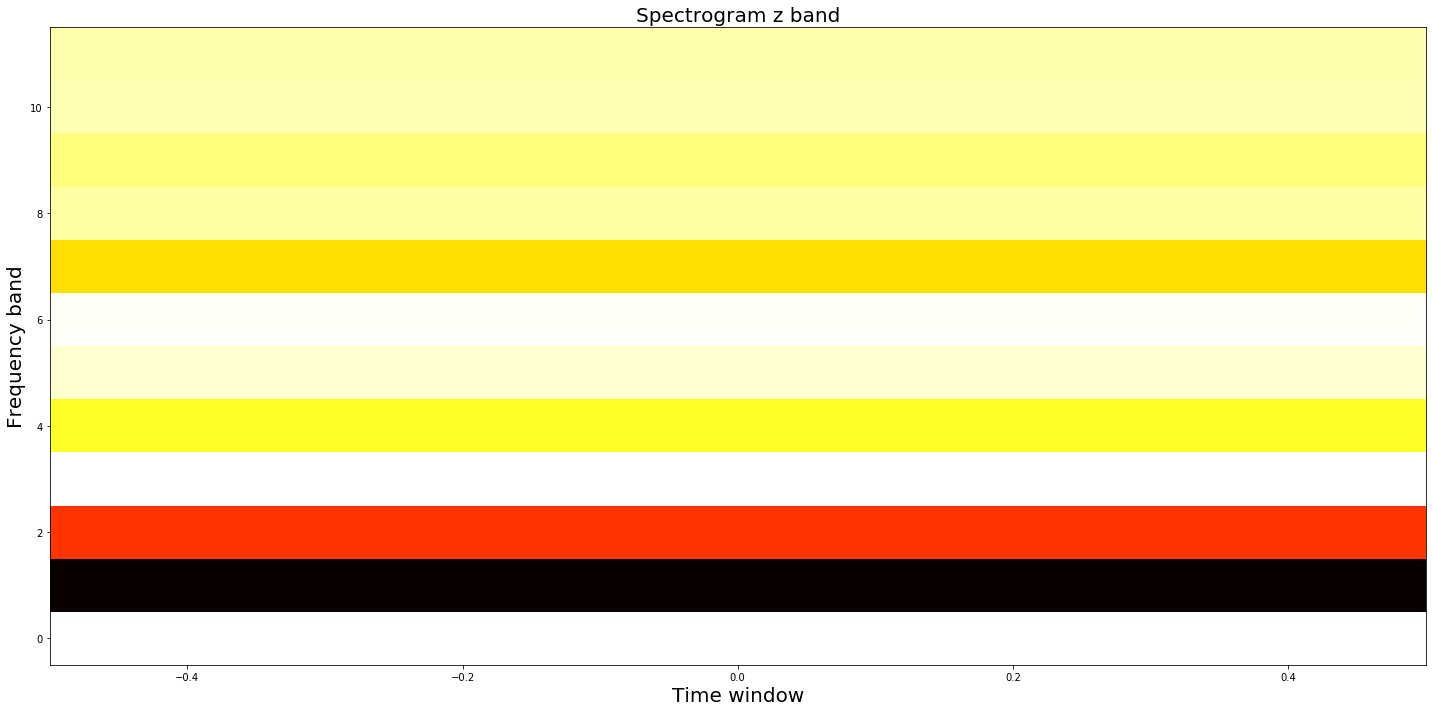

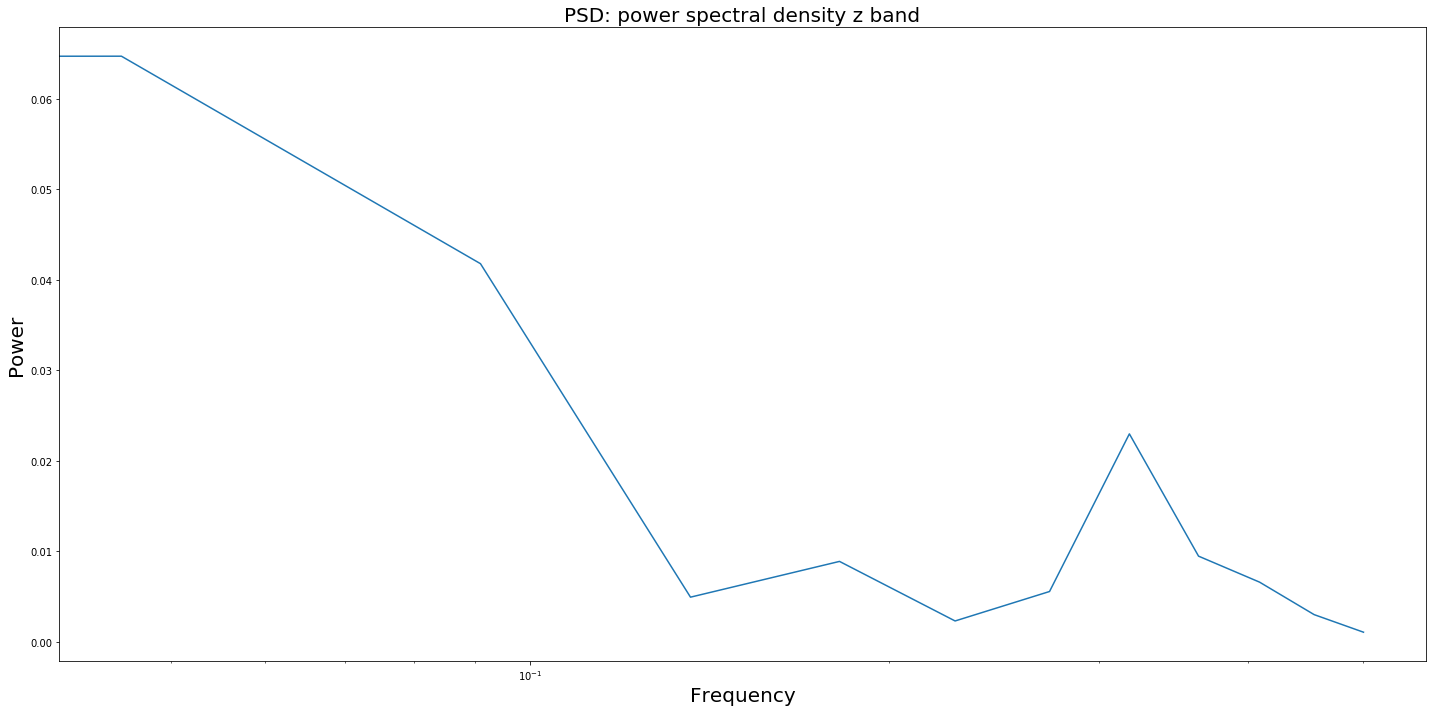

In [18]:
bands = ['u','g','r','i','z']
for i in bands:
    obs_SF_list, delta_list = calculate_obs_SF(target['mjd'], target[i],i)
    calculate_true_SF(obs_SF_list, delta_list, target[i], target[i+'_error'], i)
    caculate_ACF( obs_SF_list, delta_list,target[i], target[i+'_error'], i)
    plot_PSD(target['mjd'], target[i], i)
    

### After DRW simulation

Initial log likelihood: 8.995741912615507
parameter_dict:
OrderedDict([('kernel:a', 0.013979459342355406), ('kernel:c', 500.0), ('mean:value', 19.709935909090913)])

parameter_names:
('kernel:a', 'kernel:c', 'mean:value')

parameter_vector:
[1.39794593e-02 5.00000000e+02 1.97099359e+01]

parameter_bounds:
[(None, None), (None, None), (None, None)]

Initial log likelihood: -98.01143232603086
parameter_dict:
OrderedDict([('kernel:a', 0.0323901669448345), ('kernel:c', 500.0), ('mean:value', 19.388792272727272)])

parameter_names:
('kernel:a', 'kernel:c', 'mean:value')

parameter_vector:
[3.23901669e-02 5.00000000e+02 1.93887923e+01]

parameter_bounds:
[(None, None), (None, None), (None, None)]

Final log-likelihood: -15.485297024901982
parameter_vector:
[  3.37306381 117.18631233  19.34660048]



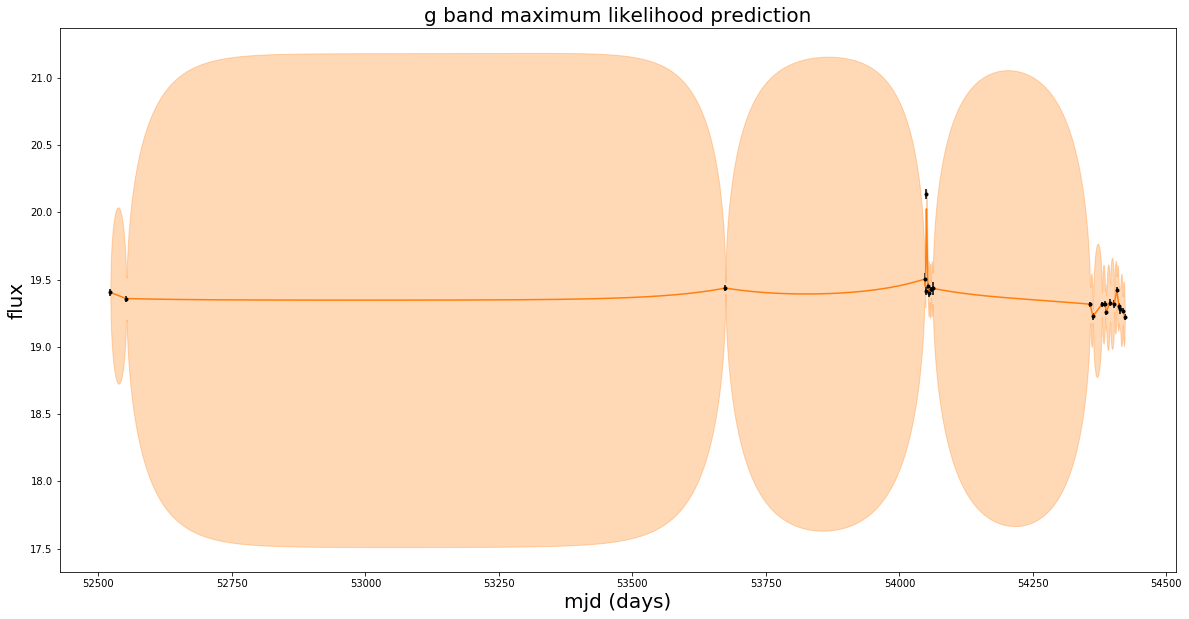

Initial log likelihood: 43.35884796207551
parameter_dict:
OrderedDict([('kernel:a', 0.005507813454545463), ('kernel:c', 500.0), ('mean:value', 19.1131)])

parameter_names:
('kernel:a', 'kernel:c', 'mean:value')

parameter_vector:
[5.50781345e-03 5.00000000e+02 1.91131000e+01]

parameter_bounds:
[(None, None), (None, None), (None, None)]

Final log-likelihood: 43.52878406306121
parameter_vector:
[5.30739822e-03 5.00000000e+02 1.91402998e+01]



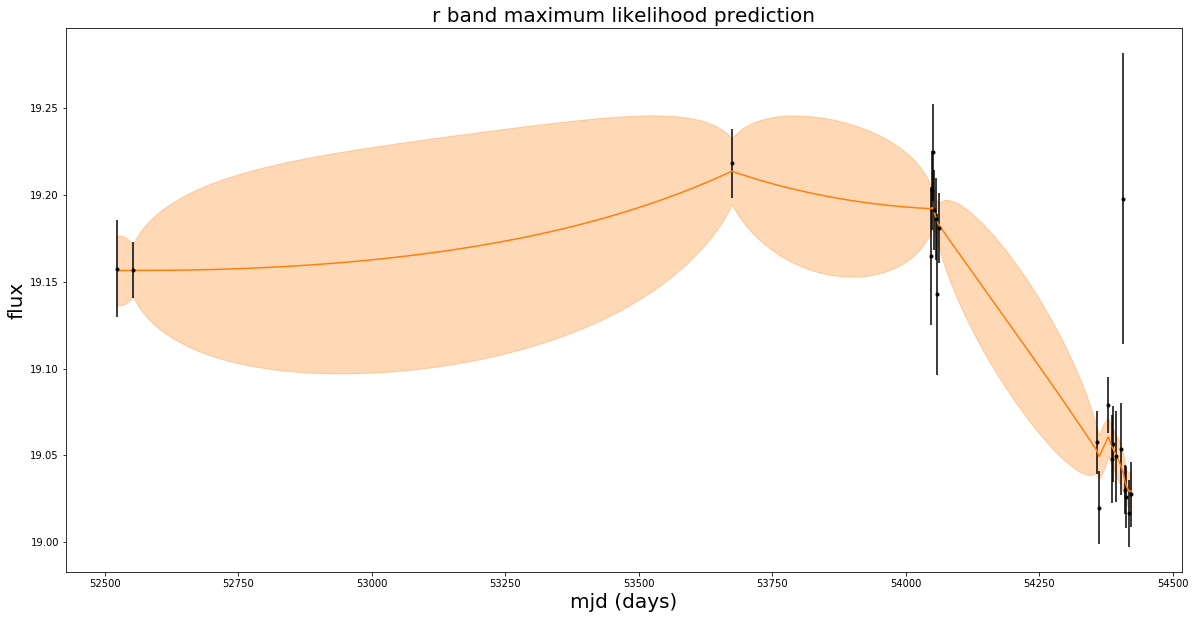

Initial log likelihood: 33.84869037572854
parameter_dict:
OrderedDict([('kernel:a', 0.0040630834140496), ('kernel:c', 500.0), ('mean:value', 18.758833636363637)])

parameter_names:
('kernel:a', 'kernel:c', 'mean:value')

parameter_vector:
[4.06308341e-03 5.00000000e+02 1.87588336e+01]

parameter_bounds:
[(None, None), (None, None), (None, None)]

Final log-likelihood: 34.10569540595492
parameter_vector:
[6.65529293e-03 4.99999992e+02 1.87721921e+01]



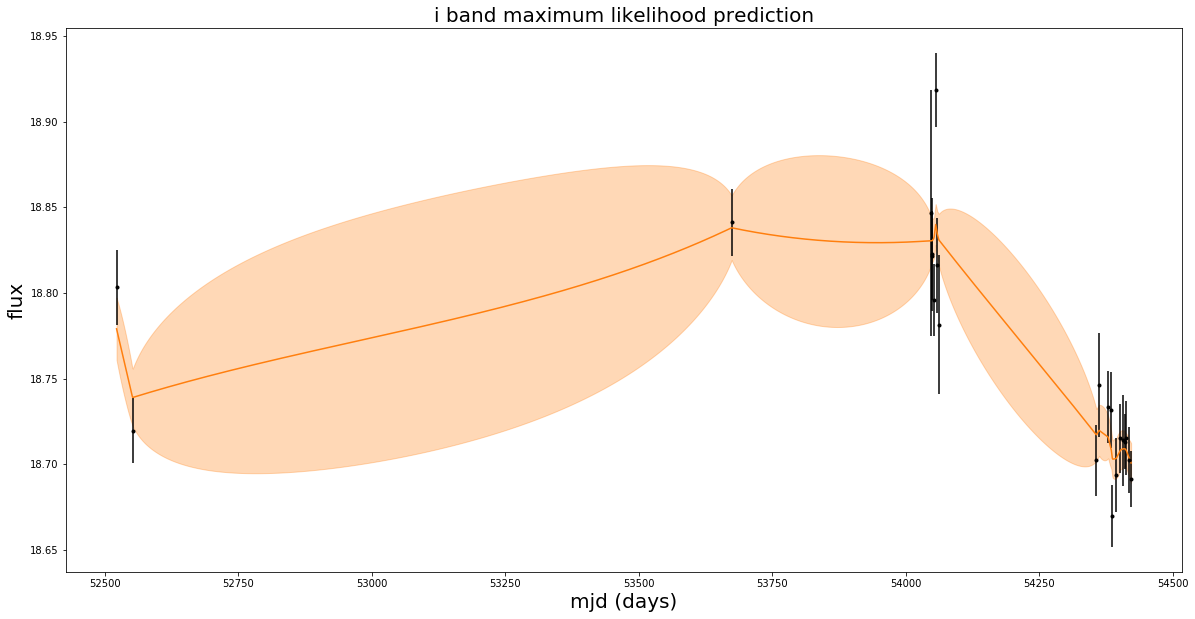

Initial log likelihood: 25.20220200137699
parameter_dict:
OrderedDict([('kernel:a', 0.009906136258057826), ('kernel:c', 500.0), ('mean:value', 18.62654681818182)])

parameter_names:
('kernel:a', 'kernel:c', 'mean:value')

parameter_vector:
[9.90613626e-03 5.00000000e+02 1.86265468e+01]

parameter_bounds:
[(None, None), (None, None), (None, None)]



In [20]:
bands = ['u','g','r','i','z']
for i in bands:
    try:
        gp = GP_lc(target['mjd'], target[i], target[i+'_error'])
        predict_lc(gp, target['mjd'], i,target[i],target[i+'_error'] )
    except:
        continue


In [21]:
passband = 'r'
gp = GP_lc(target['mjd'], target[passband], target[passband+'_error'])
mjd = target['mjd']
band = target[passband]
continuous_mjd = np.linspace(min(mjd),max(mjd),2000)
pred_mean, pred_var = gp.predict(band, continuous_mjd, return_var=True)


Initial log likelihood: 43.35884796207551
parameter_dict:
OrderedDict([('kernel:a', 0.005507813454545463), ('kernel:c', 500.0), ('mean:value', 19.1131)])

parameter_names:
('kernel:a', 'kernel:c', 'mean:value')

parameter_vector:
[5.50781345e-03 5.00000000e+02 1.91131000e+01]

parameter_bounds:
[(None, None), (None, None), (None, None)]

Final log-likelihood: 43.52878406306121
parameter_vector:
[5.30739822e-03 5.00000000e+02 1.91402998e+01]



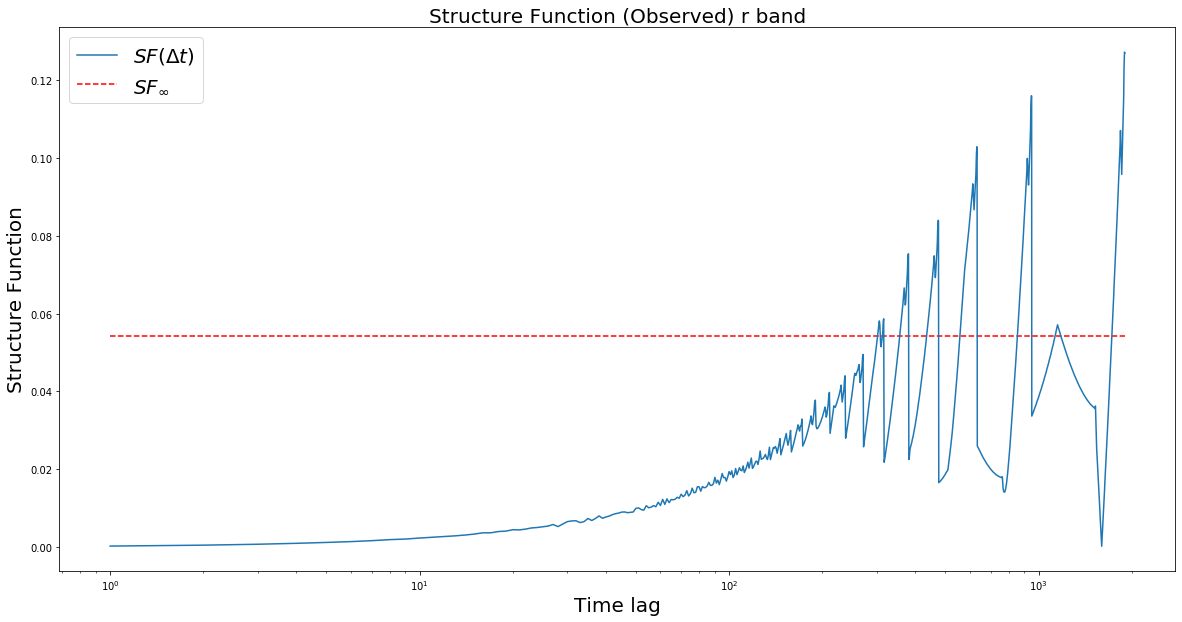

In [22]:
obs_SF_list, delta_list = calculate_obs_SF(continuous_mjd, pred_mean, passband)

/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


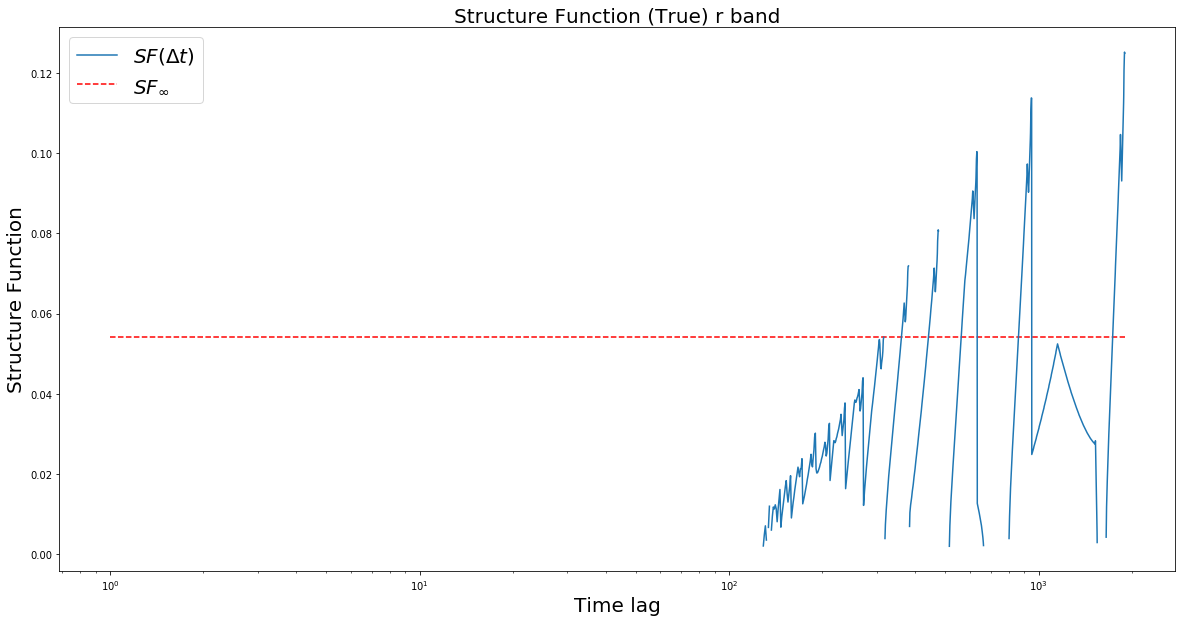

In [23]:
calculate_true_SF(obs_SF_list, delta_list, pred_mean, np.sqrt(pred_var), passband)


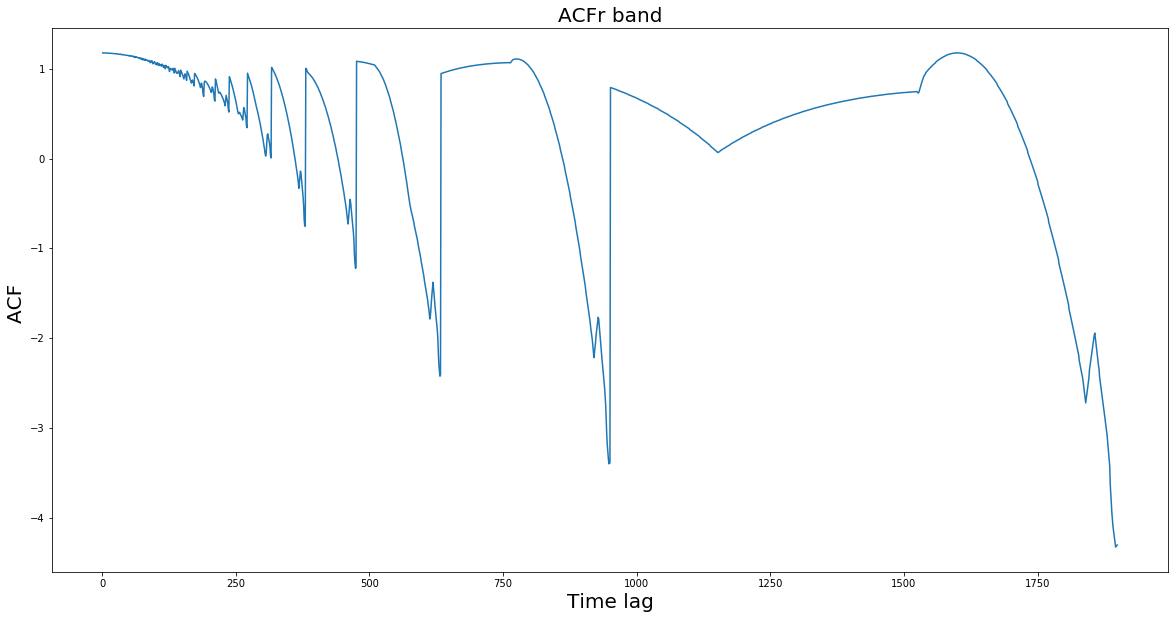

In [24]:
caculate_ACF( obs_SF_list, delta_list,pred_mean, np.sqrt(pred_var), passband)


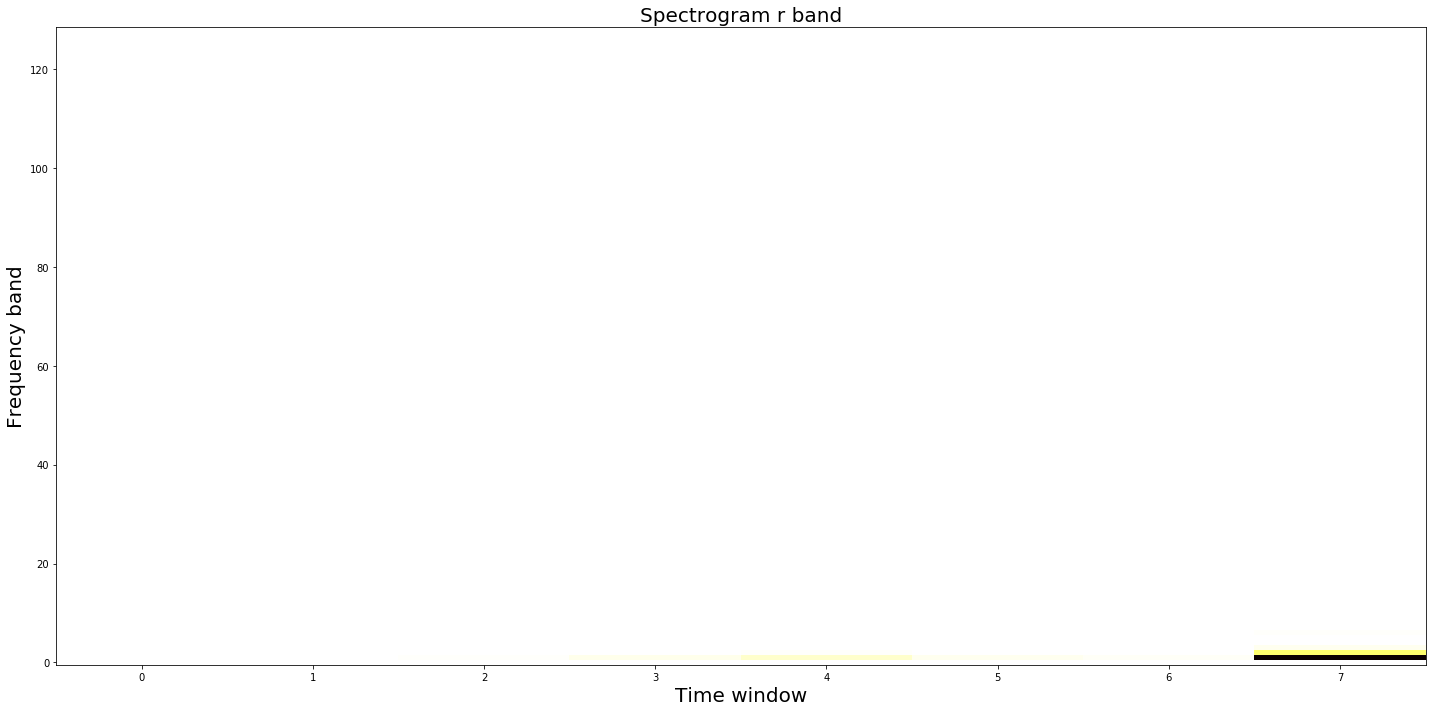

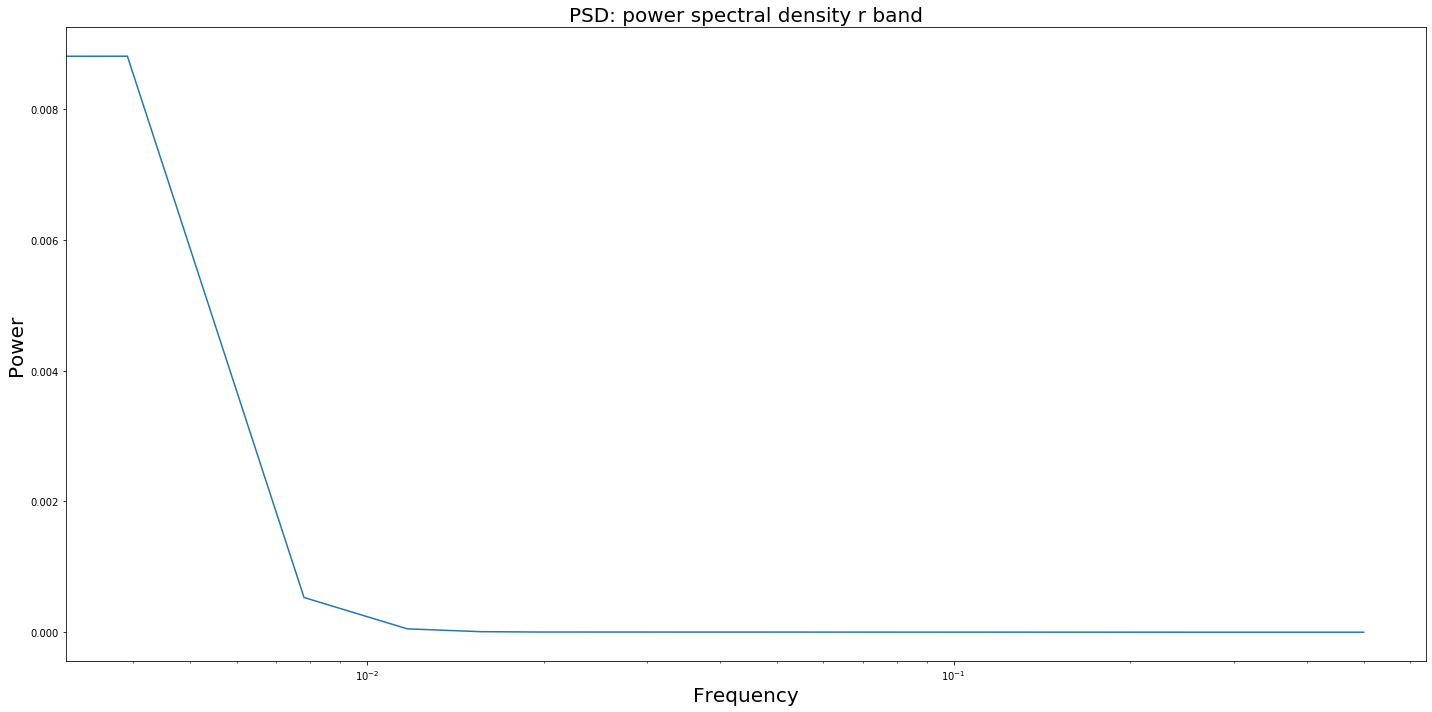

In [25]:
plot_PSD(continuous_mjd, pred_mean, passband)